In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import json

### Defining functions

In [3]:
def formatCircles(circlesData, circles):
    
    for i in range(4):
        circles.append([])
        sCircle = []
        k = 0
        for line in circlesData[i]:
            sCircle = line.split()
            iCircle = []
            for j in range(1,len(sCircle)):
                iCircle.append(int(sCircle[j]))
            circles[i].append([])
            circles[i][k] = iCircle
            k += 1

def formatFeatnames(data,featnames):
    
    for i in range(4):
        featnames.append([])
        for line in data[i]:
            splittedLine = line.split()
            word = ""
            for j in range(1,len(splittedLine)-1):
                word += splittedLine[j] + " "
            word += splittedLine[len(splittedLine)-1]
            featnames[i].append(word)

def createNodes(data,featnames,g,color):
  
    for line in data:
        splittedLine = line.split()
        j = int(splittedLine[0])
        g.add_node(j)
        g.nodes[j]['color'] = color
        k = 1
        for featname in featnames:
            g.nodes[j][featname] = splittedLine[k]
            k += 1

def createEdges(data,g):
    
    for line in data:
        words = line.split()
        e1 = int(words[0])
        e2 = int(words[1])
        g.add_edge(e1,e2)


### Reading datasets and processing data

In [4]:
circlesData = []
edgesData = []
featsData = []
featnamesData = []

for i in range(4):   
    edgesData.append(open("dataset/" + str(i) + ".edges","r"))
    featsData.append(open("dataset/" + str(i) + ".feat","r"))
    featnamesData.append(open("dataset/" + str(i) + ".featnames","r"))
    circlesData.append(open("dataset/" + str(i) + ".circles","r"))

circles = []
featnames = []

formatFeatnames(featnamesData,featnames)
formatCircles(circlesData,circles)

### Building the graph

In [5]:
# One color for each dataset:
colors = ['red','blue','chocolate','forestgreen']

# G will contain info from all datasets.
G = nx.Graph()

for i in range(4):
    createNodes(featsData[i],featnames[i],G,colors[i])
    createEdges(edgesData[i],G)

### Plotting G

In [6]:
#posG = nx.random_layout(G)  # positions for all nodes
#
#labels = {}
#for n in G.nodes:
#    labels[n] = n
#
# PLEASE SEE THE IMAGE IN THE "images" FOLDER
# 
# #nx.draw_networkx(G,
#                 pos=posG,
#                 label="Social Circles",
#                 labels=labels,
#                 with_labels=True,
#                 font_size=0.5,
#                 width=0.01,
#                 node_color= [nx.get_node_attributes(G,'color')[g] for g in G.nodes],
#                 node_size=3
#                 )
#
#plt.savefig("socialCircles.jpg",format="jpg",dpi=700)
#plt.show()

### Plotting cycles of G

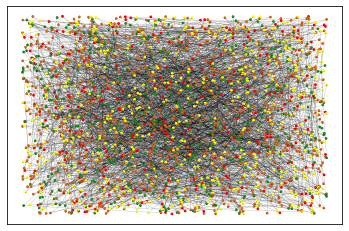

In [12]:
for i in range(5):
    for circle in circles[i]:
        c = nx.cycle_graph(circle)
        for n in circle:
            c.nodes[n]['color'] = G.nodes[n]['color']
        posc = nx.random_layout(c,dim=2)
        # PLEASE SEE THE IMAGE IN THE "images" FOLDER
        nx.draw_networkx(c,
                        pos=posc,
                        font_size=0.1,
                        width=0.1,
                        node_color= [nx.get_node_attributes(c,'color')[j] for j in                             c.nodes],   
                        node_size=3
                        )

#plt.savefig("onlyCircles.jpg",format="jpg",dpi=700)    
plt.show()

### Converting the graph to Json

In [8]:
with open('./dataset/graphs.json', 'w') as f:
    f.write(json.dumps(nx.cytoscape_data(G)))

### Closing Files

In [9]:
for i in range(5):
    circlesData[i].close()
    edgesData[i].close()
    featsData[i].close()
    featnamesData[i].close()

### Deploying on the web

In [ ]:
import os
import json
import urllib.request

import dash
import dash_html_components as html
import dash_core_components as dcc
import dash_cytoscape as cyto
from dash.dependencies import Input, Output


app = dash.Dash(__name__)
app.title = "Social Networks"
server = app.server

app.scripts.config.serve_locally = True
app.css.config.serve_locally = True


with open('./dataset/graphs.json', 'r') as f:
    data = json.loads(f.read())
    
with open('./styles/cy-style.json') as f:
    stylesheet = json.loads(f.read())

graph = data['elements']

styles = {
    'container': {
        'position': 'fixed',
        'display': 'flex',
        'flex-direction': 'row',
        'height': '100%',
        'width': '100%'
    },
    'cy-container': {
        'flex': '1',
        'position': 'relative'
    },
    'cytoscape': {
        'position': 'absolute',
        'width': '100%',
        'height': '100%',
        'z-index': 999
    },
    'responsive': {
        'margin-right': '30px',
        'height': '10%'
    },
    'list': {
        'list-style': 'none',
        'text-align': 'left'
    }
}
    
# App
app.layout = html.Div(style=styles['container'], children=[
    html.Div([
        html.Button("Responsive Toggle", id='toggle-button'),
        html.Div(id='toggle-text')
    ], style=styles['responsive']),
    html.Div([
        html.Div("Number of friends and colors", style={
            'font-size': '20', 
            'font-weight': 'bolder'
            }),
        html.Ul(children=[
            html.Li("1:   Grey",style={
                'background-color':'#333',
                'color': '#fff'
            }),
            html.Li("2:   Carmine",style={
                'background-color':'#992244', 
                'color': '#fff'
            }),
            html.Li("3:   Black", style={
                'background-color':'#000', 
                'color': '#fff'
            }),
            html.Li("4:   Purple", style={
                'background-color':'purple', 
                'color': '#fff'
            }),
            html.Li("5:   Brown", style={
                'background-color':'brown', 
                'color': '#fff'
            }),
            html.Li("6:   Yellow", style={
                'background-color':'yellow',
            }),
            html.Li("7:   Forestgreen", style={
                'background-color':'forestgreen', 
            }),
            html.Li("8:   Chocolate", style={
                'background-color': 'chocolate', 
                'color': '#fff'
            }),
            html.Li("9:   Red", style={
                'background-color':'red',
                'color': '#fff'
            }),
            html.Li("10+: Blue", style={
                'background-color':'blue',
                'color': '#fff'
            })
        ], style=styles['list'])
    ], style={'heigh': '10%'}),
    html.Div(className='cy-container', style=styles['cy-container'], children=[
        cyto.Cytoscape(
            id='cytoscape',
            elements=graph,
            stylesheet=stylesheet,
            style=styles['cytoscape'],
            layout={
                'name': 'cose',
                'idealEdgeLength': 100,
                'nodeOverlap': 100,
                'refresh': 20,
                'fit': True,
                'padding': 30,
                'randomize': False,
                'componentSpacing': 100,
                'nodeRepulsion': 40000000,
                'edgeElasticity': 100,
                'nestingFactor': 5,
                'gravity': 80,
                'numIter': 1000,
                'initialTemp': 800,
                'coolingFactor': 0.95,
                'minTemp': 1.0
            },
            responsive=True
        )
    ])
])

@app.callback(Output('cytoscape', 'responsive'), [Input('toggle-button', 'n_clicks')])
def toggle_responsive(n_clicks):
    n_clicks = 2 if n_clicks is None else n_clicks
    toggle_on = n_clicks % 2 == 0
    return toggle_on

@app.callback(Output('toggle-text', 'children'), [Input('cytoscape', 'responsive')])
def update_toggle_text(responsive):
    return '\t' + 'Responsive ' + ('On' if responsive else 'Off')

app.css.config.serve_locally = True
app.scripts.config.serve_locally = True

if __name__ == '__main__':
    app.run_server()